In [1]:
from qwak.qwak import QWAK
from utils.plotTools import plot_qwak

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
import sympy as simp
import math
import copy
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.ndimage import gaussian_filter

In [2]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst


# Single walk search

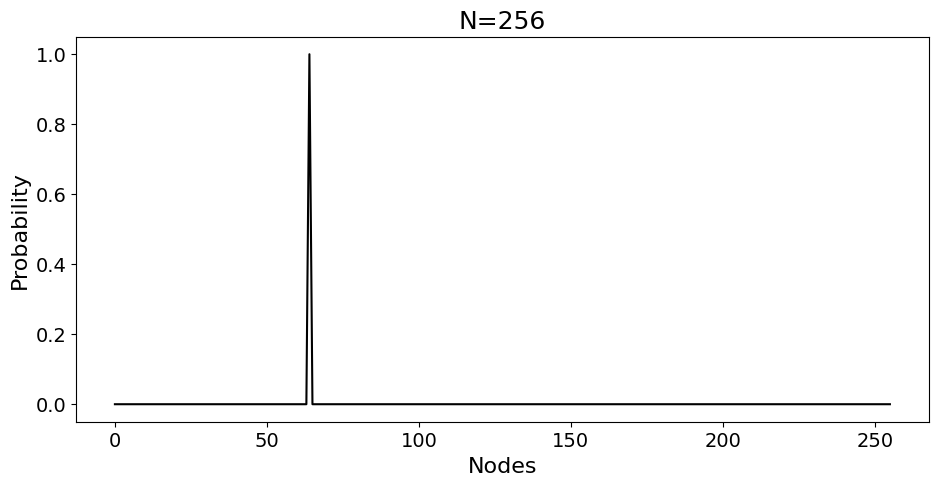

In [3]:
n = 8
N = 2**n
t = (np.pi/2) * np.sqrt(N)
gamma = 1/N
initCond = list(range(0,N))
graph = nx.complete_graph(N)

qw = QWAK(graph=graph,gamma=gamma,markedElements=[(N//4,-1)],laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'N={N}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    'legend_labels' : None,
    'legend_loc': "best",
    'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#000000'],
    'line_style_list' : ['-'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None
}
plot_qwak(x_value_matrix = list(range(0,N)), y_value_matrix = qw.getProbVec(),**params)

# Multiple walk search

In [4]:
def searchProbStepsPlotting(qwak: QWAK):
    """Plots the probability of finding the target as a function of the number of steps.

    Parameters
    ----------
    qwak : QWAK
        QWAK object containing the results of the simulation.
    """
    markedProbability = 0
    markedProbDistList = []
    markdElements = qwak.getMarkedElements()
    probDistList  = qwak.getProbDistList()
    # if probDistList == []:
    #     raise EmptyProbDistList("The probability distribution list is empty.")
    for probDist in probDistList:
        for element in markdElements:
            markedProbability += probDist.searchNodeProbability(element[0])
        markedProbDistList.append(markedProbability)
        markedProbability = 0
    return markedProbDistList

def multiple_complete_qwak(N,markedElementMatrix,gamma,initCond,graph,numberOfWalks,samples):
    markedProbMatrix = []
    timeMatrix = []
    for markedElements in markedElementMatrix:
        t = (np.pi/2) * np.sqrt(N/len(markedElements))
        print(t)
        timeList = [ x for x in np.linspace(0,t,samples)]
        qw = QWAK(graph=graph,gamma=gamma,initStateList=initCond,markedElements=markedElements)
        qw.runMultipleWalks(timeList = timeList)
        solutionProbList = searchProbStepsPlotting(qw)
        markedProbMatrix.append(solutionProbList)
        timeMatrix.append(timeList)
    return timeMatrix , markedProbMatrix

In [5]:
numberOfWalks = 3
samples = 200

n = 9
N= 2**n
print(N)
t = (np.pi/2) * np.sqrt(N)
timeList = [ x for x in np.linspace(0,t,samples)]
# print(timeList)
gamma = 1/N
initCond = list(range(0,N))
graph = nx.complete_graph(N)

markedElementsMatrix = [ 
                        [(x,-1) for x in range(0,N//16)], 
                        [(x,-1) for x in range(0,N//8)], 
                        [(x,-1) for x in range(0,N//4)] 
]

512


In [6]:
timeMatrix_file = f'Datasets/CompleteSearch/timeMatrix_N{N}_NWALKS{numberOfWalks}_S{samples}.txt'
markedProbMatrix_file = f'Datasets/CompleteSearch/markedProbMatrix_N{N}_NWALKS{numberOfWalks}_S{samples}.txt'

legend_labels = []
for marked in markedElementsMatrix:
    legend_labels.append(f'{len(marked)}')
    
if os.path.exists(timeMatrix_file) and os.path.exists(markedProbMatrix_file):
    timeMatrix = load_nested_list_from_file(timeMatrix_file)
    markedProbMatrix = load_nested_list_from_file(markedProbMatrix_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    timeMatrix,markedProbMatrix = multiple_complete_qwak(N=N,markedElementMatrix = markedElements,gamma=gamma,
                                                         initCond=initCond,graph=graph,numberOfWalks = numberOfWalks, 
                                                         samples = samples)
    if not os.path.exists(timeMatrix_file):
        write_nested_list_to_file(timeMatrix_file, timeMatrix)
    if not os.path.exists(markedProbMatrix_file):
        write_nested_list_to_file(markedProbMatrix_file, markedProbMatrix)


File exists!


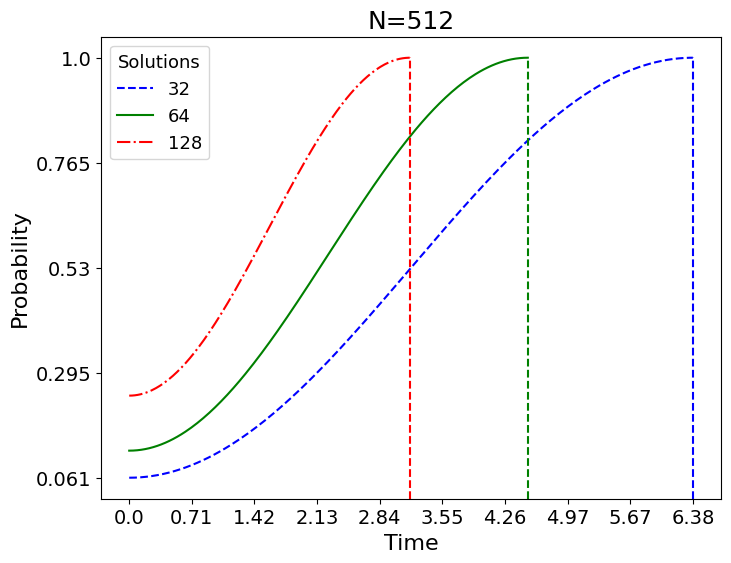

In [7]:
legend_labels = []
for marked in markedElementsMatrix:
    legend_labels.append(f'{len(marked)}')

v_line_values = []
for T, walk in zip(timeMatrix, markedProbMatrix):
    v_line_values.append((T[np.argmax(walk)],np.max(walk)))
    
params = {
    'font_size' : 14,
    'figsize': (8, 6),
    'plot_title' : f'N={N}',
    'x_label' : 'Time',
    'y_label' : "Probability",
    'legend_labels' : legend_labels,
    'legend_loc': "best",
    'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    # 'color_list' : ['#0000FF', '#008000', '#525252'],
    'color_list' : ['b','g','r'],
    'line_style_list' : ['--', '-','-.' ],
    'save_path' : f'Output/CompleteSearch/completePlot_N{N}_NWALKS{numberOfWalks}_S{samples}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 10,
    'y_num_ticks' : 5,
    'x_round_val' : 2,
    'y_round_val' : 3,
    'v_line_values' : v_line_values,
    'v_line_style': '--'
}

plot_qwak(x_value_matrix = timeMatrix, y_value_matrix = markedProbMatrix,**params)